# Sensibility

In [10]:
import openseespy.opensees as ops
import openseespy.postprocessing.ops_vis as opsv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time as tm

begin = tm.time()
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)

## Unit model kN, m 

In [2]:
def Sensibility(Fy, b, eusmax, R0, cR1, cR2, fpc, e0, Ec, ft, Ets, e20, Ecc, lambdaC, k, ecc0, ecc20):
    #Concrete
    #ops.uniaxialMaterial('Concrete02IS', 11, Ecc, fpc*k, ecc0, 0.2*fpc*k, ecc20, lambdaC, ft, 0.1*Ecc)
    #ops.uniaxialMaterial('Concrete02IS', 12, Ec, fpc, e0, 0.2*fpc, e20, lambdaC, ft, 0.1*Ec)
    ops.uniaxialMaterial('Concrete02', 11, fpc*k, ecc0, 0.2*fpc*k, ecc20, lambdaC, ft, 0.1*Ecc)
    ops.uniaxialMaterial('Concrete02', 12, fpc, e0, 0.2*fpc, e20, lambdaC, ft, 0.1*Ec)
    
    #Steel
    E0 = 200000000
    #ops.uniaxialMaterial('Steel02', 2, Fy, E0, b, R0, cR1, cR2)
    ops.uniaxialMaterial('Steel02', 2, Fy, E0, b)
    ops.uniaxialMaterial('MinMax', 21, 2, '-min', -1e16, '-max', eusmax)
    
    # Define section
    ops.section('Fiber', 1, '-GJ', 1e6)
    W = 4*25.4/1000
    H = 48*25.4/1000
    cover = (0.75-3/8*1.5)*25.4/1000
    nfcover =20
    nfcore = 20
    SB = 2*25.4/1000
    BE = 3*SB
    
    # Concrete Fibers
    # Bottom fibers
    ops.patch('rect', 11, nfcore, 1, -H/2+cover, -W/2+cover, -H/2+BE, W/2-cover)
    ops.patch('rect', 12, nfcover, 1, -H/2, -W/2, -H/2+cover, W/2)

    # Middle fibers
    ops.patch('rect', 11, nfcore, 1, -H/2+BE, -W/2+cover, H/2-BE, W/2-cover)
    ops.patch('rect', 12, nfcover, 1, -H/2+cover, -W/2, H/2-cover, -W/2+cover)  
    ops.patch('rect', 12, nfcover, 1, -H/2+cover, W/2-cover, H/2-cover, W/2)

    # Top fibers
    ops.patch('rect', 11, nfcore, 1, H/2-BE, -W/2+cover, H/2-cover, W/2-cover)
    ops.patch('rect', 12, nfcover, 1, H/2-cover, -W/2, H/2, W/2)
    
    # Steel fibers
    # Bottom Reinforcement 
    AS = 71e-6
    ops.layer('straight', 21, 2, AS, *[-H/2+cover, -W/2+cover], *[-H/2+cover, W/2-cover])
    ops.layer('straight', 21, 2, AS, *[-H/2+BE-cover-SB, -W/2+cover], *[-H/2+cover+SB, -W/2+cover])
    ops.layer('straight', 21, 2, AS, *[-H/2+BE-cover-SB, W/2-cover], *[-H/2+cover+SB, W/2-cover])
    ops.layer('straight', 21, 2, AS, *[-H/2+BE-cover, -W/2+cover+BE], *[-H/2+BE-cover, W/2-cover+BE])

    #Top Reinforcement 
    AS3 = 71e-6
    ops.layer('straight', 21, 2, AS3, *[H/2+cover-BE+cover, -W/2+cover], *[H/2+cover-BE+cover, W/2-cover])
    ops.layer('straight', 21, 2, AS3, *[H/2-BE+cover+SB, -W/2+cover], *[H/2-cover-SB, -W/2+cover])
    ops.layer('straight', 21, 2, AS3, *[H/2-BE+cover+SB, W/2-cover], *[H/2-cover-SB, W/2-cover])
    ops.layer('straight', 21, 2, AS3, *[H/2-cover, -W/2+cover], *[-H/2+BE-cover, W/2-cover])

    # Middle reinforcement
    AS2 = 32e-6
    ops.layer('straight', 21, 4, AS2, *[-H/2+BE, W/2+cover], *[H/2-BE, W/2+cover])
    ops.layer('straight', 21, 4, AS2, *[-H/2+BE, -W/2+cover], *[H/2-BE, -W/2+cover])
    
    # Nodes
    HF = 36*25.4/1000
    ops.node(1, 0.0, 0.0)
    ops.node(2, 0.0, HF)
    ops.node(3, 0.0, 2*HF)
    ops.node(4, 0.0, 3*HF)
    ops.node(5, 0.0, 4*HF)
    ops.fix(1, 1, 1, 1)

    #Elements
    ops.geomTransf('Linear', 1)
    ops.beamIntegration('Lobatto', 1, 1, 3)
    ops.element('forceBeamColumn', 1, 1, 2, 1, 1)
    ops.element('forceBeamColumn', 2, 2, 3, 1, 1)
    ops.element('forceBeamColumn', 3, 3, 4, 1, 1)
    ops.element('forceBeamColumn', 4, 4, 5, 1, 1)
    
    #Loads
    
    #Gravity
    Pcol = 0.1*fpc*W*H
    ops.timeSeries('Linear', 1)
    ops.pattern('Plain', 1, 1)
    ops.load(5, 0.0, Pcol, 0.0)
    ops.constraints('Plain')
    ops.numberer('Plain')
    ops.system('BandGeneral')
    ops.test('EnergyIncr', 1e-5, 300)
    ops.algorithm('Newton')
    NSteps = 20
    ops.integrator('LoadControl', 1/NSteps)
    ops.analysis('Static')
    ok = ops.analyze(NSteps)
    ops.wipeAnalysis()
    ops.loadConst('-time', 0.0)
    
    # Cyclic
    ops.timeSeries('Linear', 2)
    ops.pattern('Plain', 2, 2)
    ops.load(5, 1.0 , 0.0, 0.0)
    Cyclic = np.loadtxt('Cyclic.txt')
    Peaks = Cyclic[:,1]
    ops.recorder('Node', '-file', 'Task_72_CD.txt', '-time', '-node', 5, '-dof', 1, 'disp')
    CD_Cyclic_Analysis(5, 1, Peaks, 0.0009, tol=1e-6)
    ops.wipeAnalysis()
    ops.remove('recorders')

In [3]:
def DispControl(node, DOF, DeltaDisp, tol=1e-6):
    # This function run  pushover analysis with a displacement equal to DeltaDisp
    # DeltaDisp is calculated in the function LoadCyclicAnalysis
    
    # Define analysis object for pushover analysis
    ops.constraints('Plain')
    ops.numberer('RCM')
    ops.system('BandGeneral') 
    ops.test('NormDispIncr', 1e-5, 300)
    ops.algorithm('Newton')
    ops.analysis('Static')
    
    ops.integrator('DisplacementControl', 5, 1, DeltaDisp)
    ok = ops.analyze(1)
    return ok
    
    ops.wipeAnalysis()
    ops.remove('recorders')

In [4]:
def CD_Cyclic_Analysis(node, DOF, Peaks, Delta_disp, tol=1e-6):
    
    # First, creating a vector "steps" which going to help us, to know the number of steps in each peak
    steps = np.zeros(len(Peaks)-1)
    
    # Second, using a for loop calculate the steps in each peak, due to our delta displacement is constant
    for i in range (1, len(Peaks)):
        steps[i-1] = int(abs((Peaks[i]-Peaks[i-1])/Delta_disp))
        
    # Third, Apply the cyclic pushover with help of the function DispControl
    # Notice d1 is around Delta_disp, because sometimes the steps number are not an integer number 
    for j in range(1 , len(Peaks)):
        count = int(steps[j-1])
        # In order to apply the displacement step by step
        for k in range(count):
            d1 = (Peaks[j]-Peaks[j-1])/steps[j-1]
            ok = DispControl(node, DOF, d1, tol=tol)


In [5]:
Sensibility(Fy=414000, b=0.007, eusmax=0.135, R0=20, cR1=0.925, cR2=0.15, fpc=-27.6e3, e0=-0.002, Ec=27600000, 
            ft=3280, Ets=0.1*27600000, e20=-0.006, Ecc=5980000, lambdaC=0.5, k=1.3, ecc0=-0.012, ecc20=-0.0275)

WARNING analysis Static - no Integrator specified, 
 StaticIntegrator default will be used
WARNING can't set handler after analysis is created
WARNING can't set handler after analysis is created
WARNING can't set handler after analysis is created
WARNING can't set handler after analysis is created
WARNING can't set handler after analysis is created
WARNING can't set handler after analysis is created
WARNING can't set handler after analysis is created
WARNING can't set handler after analysis is created
WARNING can't set handler after analysis is created
WARNING can't set handler after analysis is created
WARNING can't set handler after analysis is created
WARNING can't set handler after analysis is created
WARNING can't set handler after analysis is created
WARNING can't set handler after analysis is created
WARNING can't set handler after analysis is created
WARNING can't set handler after analysis is created
WARNING can't set handler after analysis is created
WARNING can't set handler

Execution time: 0.77 s


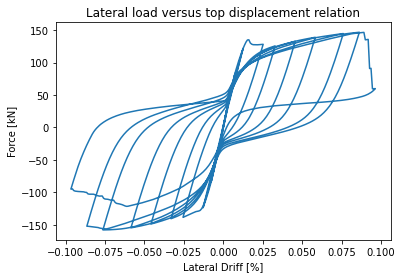

In [6]:
end = tm.time()
exc_time = end - begin
print('Execution time: {:.2f} s'.format(exc_time))
Push = np.loadtxt('Task_72_CD.txt')
plt.figure()
plt.plot(Push[:,1], Push[:,0])
plt.ylabel('Force [kN]')
plt.xlabel('Lateral Driff [%]')
plt.title('Lateral load versus top displacement relation')
plt.show()

In [128]:
# Sensibility

Test = pd.read_excel ("G:\My Drive\Investigation\Modelos y tareas Structural Walls\Task 7\Sensibility_Output.xlsx")
Test = np.array(Test)
a = len(Test[:,0])
b = len(Test[:,2])
MP = np.zeros((b,2))
Tol_disp = 0.0002
Tol_force = 7

k = 0
for i in range(b):
    for j in range(a):
        if abs(Test[j,0] - Test[i,2]) <= Tol_force and abs(Test[j,1] - Test[i,3]) <= Tol_disp:
            MP[k,0] = Test[j,0]
            MP[k,1] = Test[j,1]
            k+=1
            
#np.savetxt('Model_Points.txt', MP, delimiter=',')



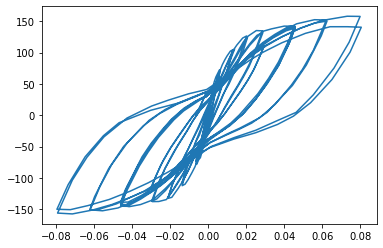